In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import plotly.offline as py 
py.init_notebook_mode(connected=True) # 為了能在本地端調用
import plotly.graph_objs as go
import plotly.tools as tls
import chart_studio.plotly as py               #plotly.plotly module is deprecated
import plotly.figure_factory as ff  #會噴error
#from plotly.tools import FigureFactory as ff
import cufflinks as cf  #這個mode
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑體
plt.rcParams['axes.unicode_minus'] = False    # 解決無法顯示符號
sns.set(font='SimHei', font_scale=0.8)     # 解决Seaborn中文顯示問題

import cufflinks error

https://community.plotly.com/t/cufflinks-error-importerror-cannot-import-name-figurewidget/25610    

Python一行代碼搞定炫酷可視化，Cufflinks值得擁有

https://kknews.cc/code/gm9mjrm.html

In [2]:
calendar = pd.read_csv('C:/Users/user/Desktop/medium文案/Finformation當資料科學遇上財務金融/toranto house data/calendar.csv')
print('資料總共有',calendar.date.nunique() , '天及' , calendar.listing_id.nunique() ,'不同的清單在我們的calendar中')
print(calendar.date.min() , calendar.date.max())
print('資料共',calendar.shape[0],'列','及',calendar.shape[1],'欄')
calendar.tail()
#calendar.info()


資料總共有 369 天及 18265 不同的清單在我們的calendar中
2021-01-02 2022-01-05
資料共 6667637 列 及 7 欄


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
6667632,47076188,2021-12-29,f,$280.00,$252.00,1.0,1125.0
6667633,47076188,2021-12-30,f,$280.00,$252.00,1.0,1125.0
6667634,47076188,2021-12-31,f,$280.00,$252.00,1.0,1125.0
6667635,47076188,2022-01-01,f,$280.00,$252.00,1.0,1125.0
6667636,47076188,2022-01-02,f,$280.00,$252.00,1.0,1125.0


資料描述:   
listing_id  
date   
available   
available t/f 為是否可以入住  t為可以訂房/f則為已被預訂  
price   
adjusted_price   
minimum_nights  
maximum_nights  

Text(0.5, 1.0, 'Available ratio')

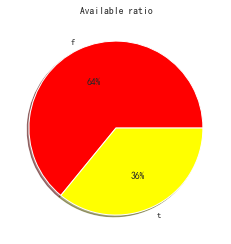

In [3]:
color = ["red", "yellow"]
labels = set([i for i in calendar['available'].values])
plt.pie(calendar.available.value_counts(), labels = labels, colors = color,autopct='%.0f%%',shadow=True,radius=1) # 繪製圓餅圖
#這邊看出空房率還是很高的
plt.title("Available ratio")

Text(0, 0.5, '%Busy')

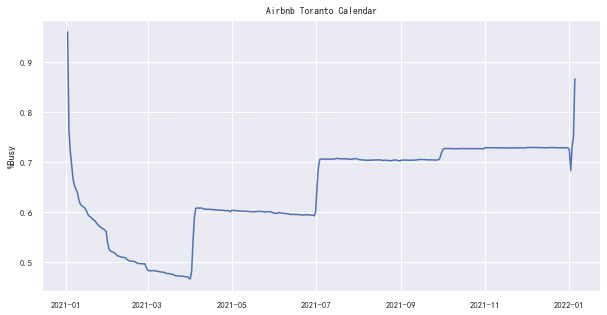

In [4]:
#想了解一年中哪些時刻淡旺季,利用時間序列與 t/f看出哪段時間空房多,就是淡季(即t較高)
#code前要先定義淡旺季的意思,數學上如何表示,再code出來
#其實旅遊業的淡旺季是有特定指標稱為「滿房率」
#因此在進行數據分析前,除了運用數學統計邏輯思考以外,可以針對資料領域的Domain knowhow進行了解再code,這樣站在巨人肩膀上
#分析的專業度上會更加提升,且更能貼合,該領域習慣,原有的分析狀態,之後才會進而做改良,不論是指標上或是BI上

new_calendar = calendar[['date' , 'available']]
new_calendar['busy'] = new_calendar.available.map(lambda x:0 if x == 't' else 1)

new_calendar = new_calendar.groupby('date')['busy'].mean().reset_index() #id每間房間在368天的 t/f加總平均為多少 0<X<1
new_calendar['date'] = pd.to_datetime(new_calendar['date'])#轉換Dtype,畫x軸時會顯示日期(plt)

plt.figure(figsize = (10 , 5))
plt.plot(new_calendar['date'] , new_calendar['busy'])
plt.title('Airbnb Toranto Calendar')
plt.ylabel('%Busy')

# 「滿房率」定義及公式

Text(0, 0.5, 'Month')

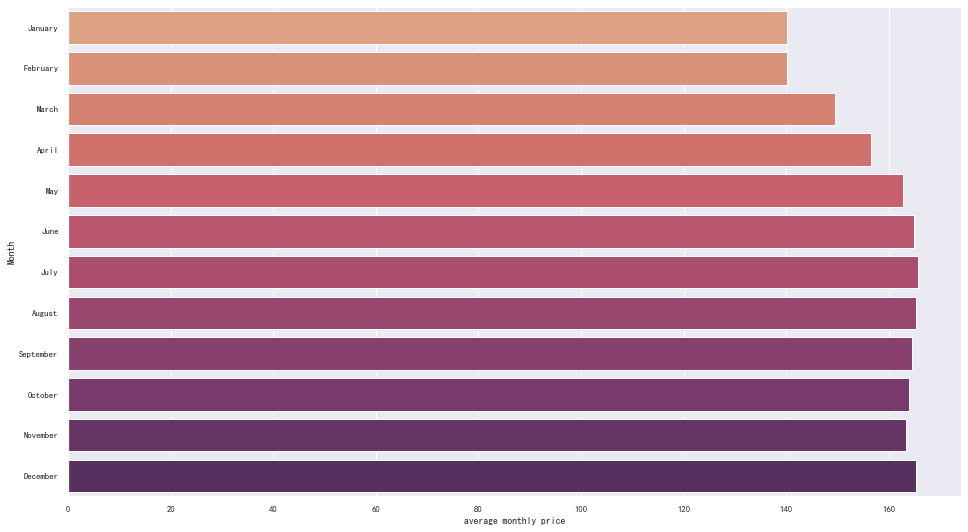

In [5]:
#再來思考商業模式中的售價,售價會影響營收,因此切入分析
#思考這筆投資在哪一月份中的 P 最高,再思考是否可以應用 Peak-load pricing 執行價格管控獲取最大利潤
#除了管理學上的理論外,culture也是很重要的,BI中數據異常時透過對local culture的了解會有助於找出原因,進而催生出解決方案
calendar['date'] = pd.to_datetime(calendar['date'])

calendar['price'] = calendar['price'].str.replace(',','').str.replace('$' , '').astype(float) #處理數據 #這裡無法重複執行,再次執行要註解掉

mean_of_month = calendar.groupby(calendar['date'].dt.strftime('%B') , sort = False)['price'].mean() #dt進階操作

#其實這個平均價格可以考慮要不要分類,listing_id為不同的物件,價格有高有低,等級也會有所不同,可以考慮以價格區分出等級再計算每個區間的價格平均
#就可以得到更細節的數據,至於價格區間如何訂定?,可以參考airbnb官網消費者選取價格的區間作為依據


#mean_of_month.plot(kind = 'barh' , figsize = (12,7))
plt.figure(figsize=(16,9)) #要先設定在數據前面
sns.barplot(y=mean_of_month.index,x=mean_of_month.values,palette="flare")
plt.xlabel('average monthly price')
plt.ylabel('Month')

Python3 pandas库(25) 时间日期高效操作   
https://zhuanlan.zhihu.com/p/31490318

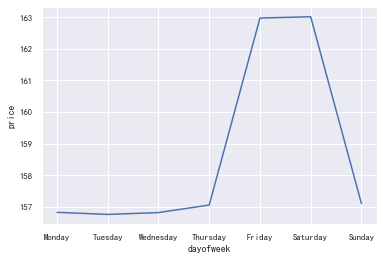

In [6]:
#1,2月份普遍比較少人來價格較低,可以深入了解為甚麼,從質量分析去找原因,及量化分析找佐證
#那我們再進一步了解週間熱門程度
import datetime
calendar['dayofweek'] = calendar.date.dt.weekday
dayofweek = []
week_days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

for i  in calendar['dayofweek']:
    a = week_days[i]
    dayofweek.append(a)
 
calendar['dayofweek'] = dayofweek

price_week = calendar.groupby('dayofweek')['price'].mean().reindex(week_days)
sns.lineplot(data=price_week,)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('bright'))

plotly   
https://plotly.com/python/ipython-notebook-tutorial/

In [7]:
#上面的價格在週五~週六突然拉高,會不會是因為跨年,數據 head,tail拉出來看,確實2022年跨年是在週五~週六,進一步思考可以如何利用columns分析

calendar.tail()
calendar.head()
s = calendar 
跨年 = s[s.date == '2021-12-31' ]['price'].mean() #指在12/31號當天的平均租房價
整年 = s['price'].mean() #整年度平均租房價
print(跨年,整年)


171.38018067341912 158.65259431489747


In [8]:
listing = pd.read_csv('C:/Users/user/Desktop/medium文案/Finformation當資料科學遇上財務金融/toranto house data/listings.csv')
listingsdeep = pd.read_csv('C:/Users/user/Desktop/medium文案/Finformation當資料科學遇上財務金融/toranto house data/listingsdeep.csv')
print('我們有' , listing.id.nunique() , '筆資料')
#listing.info()
listing.head(3)
listingsdeep.head()

我們有 18265 筆資料


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20210102020445,2021-01-02,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,https://www.airbnb.com/users/show/1565,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.11
1,8077,https://www.airbnb.com/rooms/8077,20210102020445,2021-01-04,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,https://www.airbnb.com/users/show/22795,...,10.0,10.0,10.0,NaN,t,2,1,1,0,1.22
2,12604,https://www.airbnb.com/rooms/12604,20210102020445,2021-01-02,Seaton Village Parlour Bedroom,Comfortable sofa bed in airy main floor parlou...,NaN,https://a0.muscache.com/pictures/5282025/91fca...,48239,https://www.airbnb.com/users/show/48239,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
3,23691,https://www.airbnb.com/rooms/23691,20210102020445,2021-01-03,Queen Bedroom close to downtown,<b>The space</b><br />Nestled in the middle of...,NaN,https://a0.muscache.com/pictures/615528/d09ab3...,93825,https://www.airbnb.com/users/show/93825,...,10.0,9.0,10.0,NaN,t,2,0,2,0,1.68
4,27423,https://www.airbnb.com/rooms/27423,20210102020445,2021-01-05,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",NaN,https://a0.muscache.com/pictures/176936/b687ed...,118124,https://www.airbnb.com/users/show/118124,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.20


In [9]:
listing.shape
listingsdeep.shape

(18265, 74)

In [10]:
listing.columns
listingsdeep.columns
#listingsdeep.neighbourhood_cleansed

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Understandig Data - Airbnb listing popularity analysis based on Barcelona data   
https://rstudio-pubs-static.s3.amazonaws.com/407929_afc5ef0f2ad648389447a6ca3f4a7cd4.html     
Airbnb in Seattle — Data Analysis   
https://jinglescode.github.io/2019/07/13/airbnb-in-seattle-data-analysis/    
AirBnB Analysis   
https://www.kaggle.com/aashirwad01/airbnb-analysis

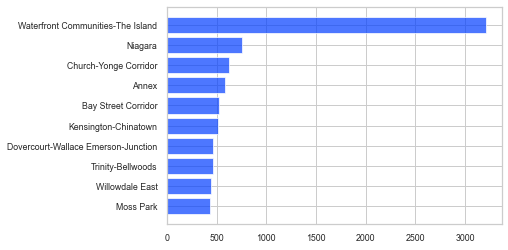

In [11]:
grouped_df = listingsdeep.groupby('neighbourhood_cleansed').count()[['id']].sort_values('id' , ascending = True).tail(10)#哪一個區域中的房源比較多

ticks = np.arange(len(grouped_df.id))
plt.barh(grouped_df.index,grouped_df.id,alpha=0.7,)
plt.show()
#Waterfront Communities-The Island 擁有房源供給非常多,可以深入研究why?

[Python 商業數據分析之可視化繪圖] 第6講：條形圖(Bar Chart)   
https://medium.com/python-%E8%B3%87%E6%96%99%E8%A6%96%E8%A6%BA%E5%8C%96/python-%E5%95%86%E6%A5%AD%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90%E4%B9%8B%E5%8F%AF%E8%A6%96%E5%8C%96%E7%B9%AA%E5%9C%96-%E7%AC%AC6%E8%AC%9B-%E6%A2%9D%E5%BD%A2%E5%9C%96-bar-chart-cdb137fb4db0  

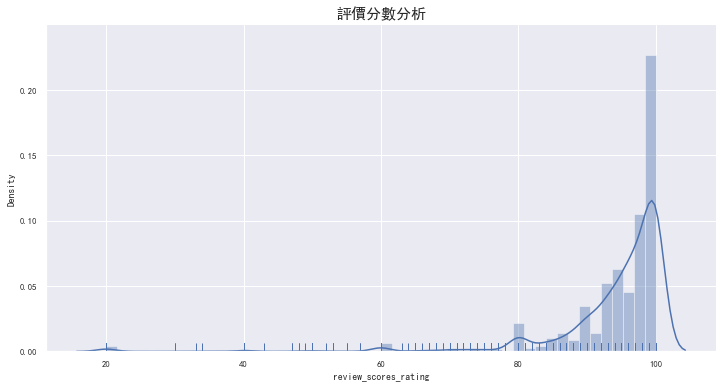

In [12]:
plt.style.use('ggplot')
sns.set(font='SimHei', font_scale=0.8)
plt.figure(figsize = (12 , 6))
plt.title('評價分數分析' , fontsize = 15)
sns.distplot(listingsdeep.review_scores_rating.dropna() , rug = True,)
sns.despine()  

count    18265.000000
mean       137.659667
std        306.423240
min          0.000000
25%         60.000000
50%         95.000000
75%        149.000000
max      13000.000000
Name: price, dtype: float64


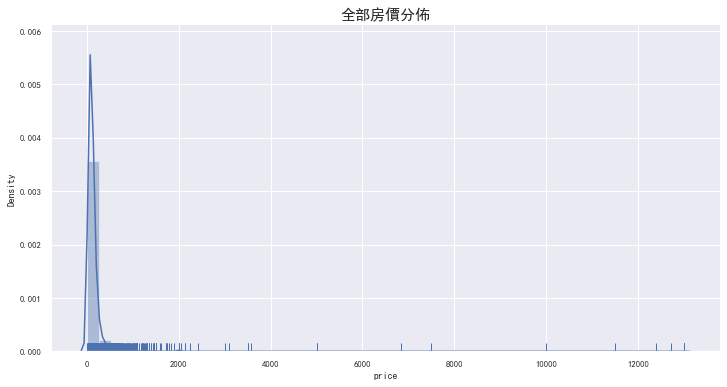

In [13]:
#當地房價分布
listingsdeep['price'] = listingsdeep['price'].str.replace(',' , '').str.replace('$' , '').astype(float)
sns.set(font='SimHei', font_scale=0.8)
print(listingsdeep.price.describe())
plt.figure(figsize = (12 , 6))
plt.title('全部房價分佈' , fontsize = 15)
sns.distplot(listingsdeep.price.dropna() , rug = True)
sns.despine()

In [14]:
# [i for i in listingsdeep.price if i >2000]
# listingsdeep[listingsdeep.price > 2000]   #.description.iloc[0] #大於2000元的房子,
# #我們可以透過description 觀察這些房子附近的生活機能,藉此了解什麼樣的房子開價這麼高~~
# #listingsdeep[listingsdeep.price >2000].sort_values('price' , ascending = False)
# listingsdeep[listingsdeep.price > 8000] #8000以上可能太貴,想排除觀察一下數據

# plt.figure(figsize = (12 , 6))
# plt.title('房價大致的分佈' , fontsize = 15)
# sns.distplot(listingsdeep[listingsdeep.price < 8000].price.dropna() , rug = True)
# sns.despine()

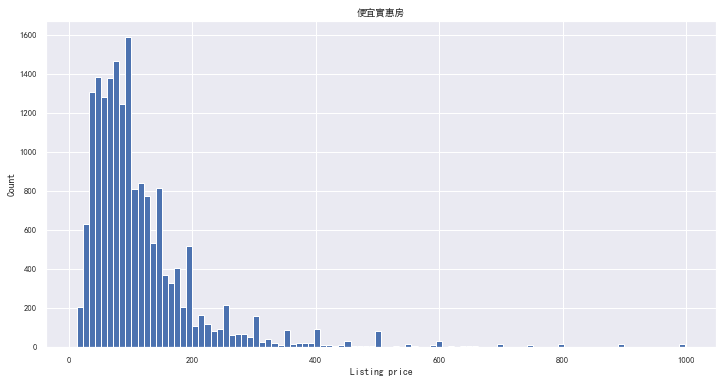

In [15]:
plt.figure(figsize = (12,6))
listingsdeep.loc[(listingsdeep.price < 1000) & (listingsdeep.price > 0)].price.hist(bins  = 100)
plt.ylabel('Count')
plt.xlabel('Listing price')
plt.title('便宜實惠房')
plt.rcParams['font.sans-serif'] = ['KaiTi']

資料來源:http://insideairbnb.com/get-the-data.html  